In [2]:
import numpy as np
import sys
from PIL import Image
import matplotlib.pyplot as plt

from pycocotools.coco import COCO
from tqdm import tqdm
from sklearn.metrics.pairwise import pairwise_distances

import operator
import skimage.io as io
from torch.utils.data import DataLoader, Dataset
import torchvision.models as models
import torchvision.transforms as transforms
import torch
from torch.autograd import Variable
import pickle

import string

from collections import defaultdict
###

In [5]:
dataDir='../coco_dataset/' #Определение директорий
imagesDirTrain = '{}train2017'.format(dataDir)
imagesDirVal = '{}val2017'.format(dataDir)

annTrainFile = '{}annotations/captions_train2017.json'.format(dataDir)
annValFile = '{}annotations/captions_val2017.json'.format(dataDir)
###

In [6]:
def tokenize(s): #Подчистка строки
    s = s.lower()
    for t in string.punctuation: 
        s = s.replace(t, ' ')
    return s


def numpy2image(img_numpy):  
    if img_numpy.dtype == np.dtype('float64'):
        img_numpy = (img_numpy*255).astype('uint8')
    return Image.fromarray(img_numpy)


class MSCOCODataset(Dataset):
    """MSCOCO Dataset"""

    def __init__(self, annFile, imagesDir, transform=None):
        self.coco = COCO(annFile)
        self.imagesDir = imagesDir
        self.imageids = self.coco.getImgIds()
        self.transform = transform

    def __len__(self):
        return len(self.coco.dataset['images'])

    def __getitem__(self, idx):
        imid = self.imageids[idx]
        img_data = self.coco.loadImgs([imid])[0]
        
        img_file_name = '{}/{}'.format(self.imagesDir, img_data['file_name'])
        image = io.imread(img_file_name)
        
        if len(image.shape) != 3:
            return self.__getitem__(0)
        
        image = numpy2image(image)
        if self.transform is not None:
            image = self.transform(image)
            
        sample = {'image': image, 'id': imid}
            
        return sample

In [7]:
def bleu(reference, candidat, n, eps=1e-5):   #Метрика для строк
    ref = list(reference.split())
    cand = list(candidat.split())
    score = 0
    
    for i in range(1, n + 1):
        ref_dict = defaultdict(int)
        cand_dict = defaultdict(int)
        
        for j in range(i, len(ref) + 1):
            ref_dict[' '.join(ref[j - i:j])] += 1
        
        for j in range(i, len(cand) + 1):
            cand_dict[' '.join(cand[j - i:j])] += 1
        
        if len(cand_dict) == 0 or len(ref_dict) == 0:
            print('\rError: Count of words is less than n')
            return
        
        sum_ = 0
        all_ = 0
        for key in cand_dict.keys():
            sum_ += min(cand_dict[key], ref_dict[key])
            all_ += cand_dict[key]
            
        score += np.log(float(sum_) / all_ + eps)
    
    score = np.exp(score / n)
    if len(cand) < len(ref):
        score *= np.exp(1 - float(len(ref)) / len(cand))
    return score


In [8]:
class KNN:#Алгоритм КБС
    def __init__(self, k, coco, model, pretrained=False):
        '''
        k: int, count of nearest neighborhood
        coco: COCO(annTrainFile), annTrainFile - file with annotations of train dataset
        model: torchvision.models, pretrained classifier model
        pretrained: bool, if True load converted images for files
        '''
        self.k = k
        self.coco = coco
        self.cnn = model
        self.mertric = bleu
        self.pretrained = pretrained
       
    def images2vec(self, loader, max_batch_iter):
        '''
        Convert each image in vector(torch array)
        loader: Dataloader(MSCOCODataset)       
        return: (torch.array, torch.array)
        '''
        assert len(loader) != 0
        
        res = None
        res_ids = None
        for i, item in tqdm(enumerate(loader)):
            
            X = Variable(item['image'].type(torch.cuda.FloatTensor))
            ids = item['id']
            
            vec = self.cnn.forward(X).data.cpu()
            
            if res is None:
                res = vec
                res_ids = ids
            else:
                res = torch.cat((res, vec), 0)
                res_ids = torch.cat((res_ids, ids), 0)
                
            if i == max_batch_iter - 1:
                break
                
        return res, res_ids
            
    def predict(self, train_loader, test_loader, max_batch_iter=10):#Работа алгоритма
        '''
        Create pretrained dataset for algorithm
        train_loader: Dataloader(MSCOCODataset)
        test_loader: Dataloader(MSCOCODataset)
        return: dict, key is <mscoco_id> of each image, value is annotation
        '''
        if len(train_loader) == 0 or len(test_loader) == 0:
            print('\rError: empty input in method predict()')
        #Обработка датасета нейронкой , если ее не было
        if self.pretrained:
            train_image = torch.load('./train_image_resnet.pth').numpy()       
            train_image_id = torch.load('./train_image_ids_resnet.pth').numpy()
            test_image = torch.load('./test_image_resnet.pth').numpy()
            test_image_id = torch.load('./test_image_ids_resnet.pth').numpy()
        else:
            test_image, test_image_id = self.images2vec(test_loader, max_batch_iter)
            train_image, train_image_id = self.images2vec(train_loader, max_batch_iter)
            
            torch.save(train_image, 'train_image.pth')
            torch.save(train_image_id, 'train_image_id.pth')
            torch.save(test_image, 'test_image.pth')
            torch.save(test_image_id, 'test_image_id.pth')
            
        print("Congratulations! All images converted")
        
        pairs = pairwise_distances(test_image, train_image) #Получаем матрицу попарных расстояний                 
        nearest_ids = np.zeros((test_image.shape[0], self.k)) #Инициализация матрицы для к соседей всех тестовых картинок
        
        for i in range(self.k):
            ids = np.argmin(pairs, 1)#Индекс из train с наименьшим расстоянием до каждой картинки из test
            nearest_ids[:, i] = ids[:]#Заполенение матрицы
            for i, idx in enumerate(ids):#Максимальное увеличение уже записанных элементов
                pairs[i, idx] = 10**3
        nearest_ids = nearest_ids.astype(np.int)#Перевод чисел в int (Было 15.0 стало 15)
        
        res = {}
        for it in tqdm(range(nearest_ids.shape[0])):#Прогон по всем тестовым картинкам
            anns_ids = self.coco.getAnnIds(imgIds=train_image_id[nearest_ids[it]])#Возврат ID аннотаций по ID картинок
            anns = self.coco.loadAnns(anns_ids) #Возврат словаря аннотаций по ID
            anns = [ann['caption'] for ann in anns] #Массив описаний картинки
            dist_sim = np.zeros((len(anns), len(anns)))#Инициализация матрицы похожести описаний
            
            for i in range(len(anns)):   #Заполнение этой матрицы
                for j in range(i + 1, len(anns)):
                   
                    dist_sim[i][j] = self.mertric(tokenize(anns[i]), tokenize(anns[j]), 4)
                    dist_sim[j][i] = self.mertric(tokenize(anns[j]), tokenize(anns[i]), 4)
                    
            dist_sim_sum = dist_sim.sum(0)#Сумма метрик по всем описаниям
            #np.argmax(dist_sim_sum)-Индекс описания для которого выполняется аргмакс
            res[test_image_id[it]] = anns[np.argmax(dist_sim_sum)] #Возвращается лучшее описание
            
        return res

In [9]:
transform = transforms.Compose([transforms.Resize((224, 224)), 
                                             transforms.ToTensor(), 
                                             transforms.Normalize(
                                                 mean=[0.485, 0.456, 0.406],
                                                 std=[0.229, 0.224, 0.225])])

train_dataset = MSCOCODataset(annTrainFile, imagesDirTrain, transform)
test_dataset = MSCOCODataset(annValFile, imagesDirVal, transform)

train_dataloader = DataLoader(train_dataset, batch_size=128)
test_dataloader = DataLoader(test_dataset, batch_size=32)

loading annotations into memory...
Done (t=1.12s)
creating index...
index created!
loading annotations into memory...
Done (t=0.06s)
creating index...
index created!


In [ ]:
m = KNN(20, COCO(annTrainFile), None, True)

In [ ]:
res = m.predict(train_dataloader, test_dataloader, 100)

In [6]:
val_coco = COCO(annValFile)#Инициазизация объекта для тестовой выборки
###

loading annotations into memory...
Done (t=0.05s)
creating index...
index created!


In [7]:
res = {}    #Выгрузка ответов из файла
with open('./res-2.txt', 'r') as f:
    for line in f:
        line = line.strip()
        if len(line) == 0:
            continue
        line = line.split(maxsplit=1)
        res[int(line[0])] = line[1]
###


KNN: A guy sitting at a table in front of a birthday cake with candles in the cake

Ref: A boy getting ready to blow out candles on a birthday cake.
Ref: A young boy about to blow out candles
Ref: A boy is blowing his candles on his ninth birthday.
Ref: a young kid sits in front of a birth day cake 
Ref: A boy getting ready to blow out birthday candles with a girl watching.


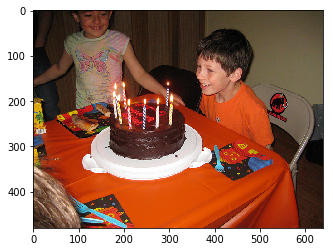

In [16]:
for i, key in enumerate(res.keys()): #Вывод результатов 
    if i != 99:
        continue
    img_data = val_coco.loadImgs([key])[0]
    img_file_name = '{}/{}'.format(imagesDirVal, img_data['file_name'])
    image = io.imread(img_file_name)
    plt.imshow(image)
    print('\nKNN: {}\n'.format(res[key])) 
    
    anns_ids = val_coco.getAnnIds([key])
    anns = val_coco.loadAnns(anns_ids)
    anns = [ann['caption'] for ann in anns]
    for l in anns:
        print('Ref: ' + l)
    break
###